Loading the packages:

In [1]:
import numpy as np
import scipy.linalg as lina
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import os # Flexible loading and saving dataframs from/to csv files
import ast # Module to parse string representations of dictionaries
import hdbscan # For clustering solution dataframes
from sklearn.preprocessing import StandardScaler # Used in clustering function
import warnings
warnings.simplefilter('ignore')

# System Model

Initially, only the equation for one state (temperature or concentration) will be considered. For simplicity, the domain will be $[0,1]$, with Danckwerts boundary conditions:

$$\left\{\begin{array}{l} \dot{x} = D\partial_{\zeta\zeta} x -v\partial_{\zeta} x +kx\\
D\partial_\zeta x(0,t)-vx(0,t)=-v[Rx(1,t-\tau)+(1-R)u(t-\tau_I)] \\
\partial_\zeta x(1,t)=0 \\
y(t)=x(1,t-\tau_O)
  \end{array}\right. $$

This model considers that the input is applied in the reactor's entrance, which is mixed with the recycle from the outlet. Input, output, and state delays are considered and represented by $\tau_I,\tau_O$, and $\tau$, respectively. 

Initializing system parameters:

In [2]:
default_pars = {
    'k':10,
    'D':0.1,
    'v':0.5,
    'tau':1,
    'R':0.9,
    'label':'default'
}

## Eigenvalue Analysis

The eigenvalue problem, defined as $A\Phi(\zeta,\lambda)=\lambda\Phi(\zeta,\lambda)$, will result in the following system of equation for this system:

$$\left\{\begin{array}{l} \lambda\phi = D\partial_{\zeta\zeta} \phi -v\partial_{\zeta} \phi +k\phi\\
\lambda\phi_D=\dfrac{1}{\tau}\partial_{\zeta}\phi_D\\
D\partial_\zeta \phi(0)-v\phi(0)=-Rv\phi_D(0) \\
\partial_\zeta \phi(1)=0 \\
\phi_D(1)=\phi(1)\\
  \end{array}\right. $$

where $\Phi=[\phi,\,\phi_D]^T$, with $\phi$ as the state eigenfunction and $\phi_D$ as the eigenfunction related to the delay. By defining $X=[\phi,\, \partial_{\zeta}\phi,\,\phi_D]^T$, the following system of ODEs is obtained:

$$
\left\{\begin{array}{l}\partial_{\zeta}X=\begin{bmatrix} 0 & 1 & 0\\ \dfrac{\lambda-k}{D} & \dfrac{v}{D} & 0\\0 & 0 & \tau\lambda\end{bmatrix}X=ΛX \\
DX_2(0)-vX_1(0)=-RvX_3(0) \\
X_2(1)=0 \\
X_3(1)=X_1(1)\\ \end{array}\right.
$$

## Characteristic Equation

This is a system of first order ODE's, and the solution to such systems is given by:

$$ X(\zeta, \lambda) = e^{\Lambda \zeta} X (\zeta=0, \lambda) \\ \overset{\zeta = 1}{\Rightarrow} X(1, \lambda) = e^{\Lambda} X (\zeta=0) $$

Now, let's assume:

$$ e^{\Lambda} = Q(\lambda) = \begin{bmatrix} 
        q_{1} & q_{2} & q_{3} \\ q_{4} & q_{5} & q_{6} \\ q_{7} & q_{8} & q_{9}
    \end{bmatrix} $$


Thus, we may write:

$$\left\{\begin{array}{l}
X_1(1) = q_1 X_1(0) + q_2 X_2(0) + q_3 X_3(0) \\
X_2(1) = q_4 X_1(0) + q_5 X_2(0) + q_6 X_3(0) \\
X_3(1) = q_7 X_1(0) + q_8 X_2(0) + q_9 X_3(0)
\end{array}\right.$$

Now, we may go ahead and put the above expressions into boundary conditions to get the following:

$$\left\{\begin{array}{l}
Dx_2-vx_1=-Rvx_3 \\
q_4 x_1 + q_5 x_2 + q_6 x_3 = 0 \\
q_7 x_1 + q_8 x_2 + q_9 x_3 = q_1 x_1 + q_2 x_2 + q_3 x_3
\end{array}\right. \Rightarrow \left\{\begin{array}{l}
-vx_1 + Dx_2 + Rvx_3 = 0 \\
q_4 x_1 + q_5 x_2 + q_6 x_3 = 0 \\
(q_1 - q_7) x_1 + (q_2 - q_8) x_2 + (q_3 - q_9) x_3 = 0
\end{array}\right.$$


where $x_i$ is the same as $X_i(0)$.

For this particular case, we know that:

$$ q_{3} = q_{6} = q_{7} = q_{8} = 0 $$

This will further simplify the above system of equions into the following system:

$$\left\{\begin{array}{l}
-vx_1 + Dx_2 + Rvx_3 = 0 \\
q_4 x_1 + q_5 x_2 = 0 \\
q_1 x_1 + q_2 x_2 - q_9 x_3 = 0
\end{array}\right.$$

This is a $3 \times 3$ system of algebraic equations in the form of $\bar{A} \bar{x} = 0 $, with:

$$ \bar{A} = \begin{bmatrix}
-v & D & Rv \\
q_4 & q_5 & 0 \\
q_1 & q_2 & -q_9
\end{bmatrix}; \quad \bar{x} = \begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix} $$

 For such a system to have non-trivial solution (i.e. $\bar{x} \neq 0$), the dimension of the nullspace of the coefficients matrix $\bar{A}$ needs to be non-zero. This will happen if and only if the coefficients matrix $\bar{A}$ is rank-deficient. One way to make sure matrix $ \bar{A} $ is not full-rank, is to set a linear combination of its rows to be zero, with non-zero coefficients. Multiplying the second row of the matrix by $\alpha$ and the third row by $\beta$, we can write:

$$
\left\{\begin{array}{l}
-v + \alpha q_4 + \beta q_1 = 0 \\
D + \alpha q_5 + \beta q_2 = 0 \\
-Rv - \beta q_9 = 0 
\end{array}\right.
\Rightarrow
\left\{\begin{array}{l}
\alpha q_4 + \beta q_1 = v \\
\alpha q_5 + \beta q_2 = -D \\
\beta q_9 = -Rv 
\end{array}\right.
$$

The above system is a system of 3 equations and 3 unknowns (i.e. $\alpha$, $\beta$, and $\lambda$, with $\lambda$ being hidden in $q_i$ terms). By writing $\alpha$ and $\beta$ variables based on $q_i$ terms, we can get the characteristic equation.

Using the third equation, we can get:

$$ \beta = \frac{-Rv}{q_9} $$

Using the above equation to replace $\beta$ into the second equation will result in:

$$ \alpha = \frac{v}{q_4} \left(1 + \frac{R q_1}{q_9} \right) $$

Therefore, we can put the above expressions for $\alpha$ and $\beta$ into the first equation to get the characteristic equation, which is a non-linear function of the eigenvalue of the system, $\lambda$:

$$ f(\lambda) = D + v \frac{q_5}{q_4} \left( 1 + \frac{R q_1}{q_9} \right) - Rv \frac{q_2}{q_9} = 0 $$

We may now multiply both sides of the charactersitic equation by $q_4 q_9$ to avoid numerical errors while solfing for $f(\lambda)$. This will give:

$$ g(\lambda) = D q_4 q_9 + v [ q_5 q_9 + R (q_1 q_5 - q_2 q_4)] = 0 $$

## Numerical Solution

First we define a function to find the eigenvalues for the above characteristic equation. This function takes optional keyword argument as shown in the function docstring, returning a tuple with the following:

- solution_df: A pandas dataframe of all the solutions found based on the given arguments.
- par['label']: A string that briefly explains the parameters resulting in the obtained eigenvalue distribution.

P.S.: There is another function embeded inside the function below, that gives the value of the characteristic equation at each $\lambda$.

In [3]:
def char_eq_1(x): # To be more simplified
    """
    This function evaluates the charachteristic equation at a given point.

    Parameters:
        x ([float, float]):
            A list of 2 elements, making up the Re and Im parts of the complex eigenvalue to calculate char_eq.
    
    Returns:
        array[float, float]:
            An array of 2 elements, making up the Re and Im parts of the complex value of char_eq at the given x.
    """
    global global_par # To access 'global_par', defined within 'find_eig()' function as a global variable.
    par = global_par
    l = complex(x[0], x[1])
    
    (k, v, D, t, R) = (par['k'], par['v'], par['D'], par['tau'], par['R'])
    p = v**2 - 4*D * (k-l)
    p_sqrt = np.sqrt(p)
    if np.isclose(p_sqrt,0, atol=1e-8):
        y = (
            np.exp(l*t+v/2/D) * np.sinh(np.sqrt(p)/2/D) * (v**2 + 2*D**2)
            + v * np.sqrt(p) * (np.cosh(np.sqrt(p)/2/D)-R*np.exp(v/D))
        )
    else:
        y = (
            np.exp(l*t+v/2/D) * (v**2 + 2*D**2)
            + v * (1-R*np.exp(v/D))
        )

    return np.array([y.real, y.imag])


def find_eig(**kwargs):
    """
    This function solves the char equation in complex plane for different initial guesses.

    Parameters:
        **kwargs (keyword arguments):            
            - par (dict): A dictionary containing parameters for the system's matrix. If not provided, keys may be passed separately. Absent keys will take default values.
            - guess_single (complex): A single initial guess for eigenvalue calculation (real + imaginary part).
            - guess_range_real (list): A list specifying the range of real parts of initial guess values.
            - guess_range_imag (list): A list specifying the range of imaginary parts of initial guess values.
            - tol_1 (float): Tolerance for initial guess refinement.
            - tol_2 (float): Tolerance for final eigenvalue precision.
            - tol_multiplier (float): Multiplier for refining tolerance in the final solution.
            
    Returns:
        tuple:
            A tuple containing:
            
            - solution_df (pandas.DataFrame): DataFrame containing found solutions' information.
            - label (str): A label describing the customized parameters used for the computation.
            - metadata (dict): A dictionary containing input parameter values used in the computation.
    """
    
    # Assign default values to missing keyword arguments for parameters
    label_needed = False
    if 'par' in kwargs:
        par = kwargs['par']
        if par['label'] == '':
            label_needed = True
    else:
        par = default_pars.copy()
        for key in par:
            par[key] = kwargs.get(key, par[key])
        if par != default_pars:
            label_needed = True
    # Creating a label for parameters if needed
    if label_needed:
        differing_pairs = {key: value for key, value in par.items() if not np.isclose(value, default_pars[key])}
        par['label'] = '_'.join([f"({key}_{value:.3g})" for key, value in differing_pairs.items()])
    
    global global_par # Store 'par' as a global variable
    global_par = par # So that it can be accessed by char_eq(x), without being passed to it
            
    # Assign default values to missing keyword arguments for initial guess values
    if 'guess_single' in kwargs:
        guess_single_r = np.real(kwargs['guess_single'])
        guess_single_i = np.imag(kwargs['guess_single'])

        guess_range_real = [guess_single_r, guess_single_r, 1]
        guess_range_imag = [guess_single_i, guess_single_i, 1]
    else:
        guess_range_real = kwargs.get('guess_range_real', [-100,-100,1])
        guess_range_imag = kwargs.get('guess_range_imag', [5,5,1])
    
    # Assign default values to the rest of missing keyword arguments
    tol_1 = kwargs.get('tol_1', 1e-4)
    tol_2 = kwargs.get('tol_2', 1e-15)
    tol_multiplier = kwargs.get('tol_multiplier', 100)

    metadata = {
        'par' : par,
        'guess_range' : (guess_range_real, guess_range_imag),
        'tols' : (tol_1, tol_2, tol_multiplier)
    }

    # Constructiong a dictionary to capture legit solutions
    solution_dict = {
        'Sol_r':[],'Sol_i':[],'Guess_r':[],'Guess_i':[],'g(x)':[]
        }

    # Constructiong a 2D (Re-Im plane) mesh for different initial guess values
    mesh_builder = np.meshgrid(
        np.linspace(guess_range_real[0],guess_range_real[1],guess_range_real[2]),
        np.linspace(guess_range_imag[0],guess_range_imag[1],guess_range_imag[2])
        )
    mesh = mesh_builder[0] + mesh_builder[1] * 1j
    
    for i in mesh:
        for m in i:
            m = np.array([m.real, m.imag]) # obtaining an initial guess from the mesh as a complex number
            solution_array_initial = opt.fsolve(char_eq,m,xtol=tol_1) # solving char_eq with a relaxed tol
            is_sol_initial = char_eq(solution_array_initial) # evaluationg the value of char_eq at the obtained relaxed solution
            is_sol_initial = (abs(complex(is_sol_initial[0],is_sol_initial[1])))
            # An inner loop seems to be necessary as sometimes the fsolve gives incorrect results that are ~+-2*pi from the radial complex answer of the real solution
            if np.isclose(is_sol_initial,0,atol=tol_1*tol_multiplier):
                solution_array = opt.fsolve(char_eq,solution_array_initial,xtol=tol_2)
                is_sol = char_eq(solution_array) # evaluationg the value of char_eq at the obtained relaxed solution
                is_sol = (abs(complex(is_sol[0],is_sol[1])))
                if np.isclose(is_sol,0,atol=tol_2*tol_multiplier):
                    solution_dict['Guess_r'].append(m[0])
                    solution_dict['Guess_i'].append(m[1])
                    solution_dict['g(x)'].append(is_sol)
                    solution_dict['Sol_r'].append(solution_array[0])
                    solution_dict['Sol_i'].append(solution_array[1])
                    solution_array_conj_guess = solution_array.copy()
                    solution_array_conj_guess[1] *= -1
                    solution_array_conj = opt.fsolve(char_eq,solution_array_conj_guess,xtol=tol_2)
                    is_sol_conj = char_eq(solution_array_conj) # evaluationg the value of char_eq at the obtained relaxed solution
                    is_sol_conj = (abs(complex(is_sol_conj[0],is_sol_conj[1])))
                    if np.isclose(is_sol_conj,0,atol=tol_2*tol_multiplier):
                        solution_dict['Guess_r'].append(m[0])
                        solution_dict['Guess_i'].append(-m[1])
                        solution_dict['g(x)'].append(is_sol_conj)
                        solution_dict['Sol_r'].append(solution_array_conj[0])
                        solution_dict['Sol_i'].append(solution_array_conj[1])
    
    del global_par # Avoid storing a global parameter after making use of it

    solution_df = pd.DataFrame(solution_dict)
    solution_df = solution_df.sort_values(by=['Sol_r'])
    return (solution_df, par['label'], metadata)

We also define a handful of functions to write csv files of solution dataframes that have parameters' label as their metadata, and vice versa:

In [4]:
def save_dataframe_to_csv(df, filename, parent_dir=None, metadata=None):
    """
    Save a DataFrame to a CSV file, optionally with metadata in the first line.

    Args:
        df (pd.DataFrame): The DataFrame to be saved.
        filename (str): The name of the output CSV file.
        parent_dir (str, optional): The parent directory to save the file in. If None, saves in the current directory.
        metadata (str, optional): Metadata to be stored in the first line of the CSV file as a comment.

    Returns:
        None
    """
    if parent_dir:
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        output_filepath = os.path.join(parent_dir, filename)
    else:
        output_filepath = filename
    
    counter = 1
    while os.path.exists(output_filepath):
        # If the file already exists, generate a new filename with an incremental suffix
        base_name, ext = os.path.splitext(filename)
        output_filepath = os.path.join(parent_dir, f"{base_name}_{counter}{ext}")
        counter += 1
        
    if metadata is None:
        df.to_csv(output_filepath, index=False)
        print(f"DataFrame saved to {output_filepath}")
    else:
        with open(output_filepath, 'w') as f:
            f.write(f"# {metadata}\n")
            df.to_csv(f, index=False)
        print(f"DataFrame with metadata '{metadata}' saved to {output_filepath}")

def load_dataframe_from_csv(input_filepath):
    """
    Load a DataFrame from a CSV file, along with metadata if present in the first line.

    Args:
        input_filepath (str): The path to the input CSV file.

    Returns:
        pd.DataFrame: The loaded DataFrame.
        str: The base filename (without extension) of the input file.
        str or None: Metadata if present, else None.
    """
    with open(input_filepath, 'r') as f:
        metadata_line = f.readline().strip()
        if metadata_line.startswith('#'):
            metadata = metadata_line.lstrip('# ').strip()
            df = pd.read_csv(input_filepath, comment='#')
        else:
            metadata = None
            df = pd.read_csv(input_filepath)
    
    base_filename = os.path.splitext(os.path.basename(input_filepath))[0]
    return df, base_filename, metadata


def create_custom_pars_list(csv_path):
    """
    Create a list of custom parameter dictionaries from a CSV file.

    This function reads a CSV file located at the given path and constructs a list
    of dictionaries, where each dictionary represents custom parameters based on
    the CSV content and a global default_pars dictionary.

    Parameters:
        csv_path (str): The path to the CSV file.

    Returns:
        list: A list of dictionaries containing custom parameter sets.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Initialize a list to store dictionaries
    custom_pars_list = []
    
    # Use the global default_pars variable
    global default_pars

    # Iterate through the rows of the DataFrame
    for index, row in df.iterrows():
        custom_pars = default_pars.copy()
        
        # Update custom_pars with values from the current row
        for key in default_pars.keys():
            if key in row:
                custom_pars[key] = row[key]
        
        # Append the customized parameter dictionary to the list
        custom_pars_list.append(custom_pars)
    
    return custom_pars_list

def cluster(input_df, min_cluster_size):
    """
    Generate a representative DataFrame from an input DataFrame using HDBSCAN clustering.

    Parameters:
        input_df (pd.DataFrame): The input DataFrame with 'x' and 'y' columns.
        min_cluster_size (int): Minimum number of points to form a cluster (default is 2).

    Returns:
        pd.DataFrame: A DataFrame containing one representative point from each cluster.
    """
    # Standardize the data
    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(input_df[ ['Sol_r', 'Sol_i']])
    
    # Apply HDBSCAN clustering
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    labels = hdbscan_clusterer.fit_predict(points_scaled)
    
    # Create a new DataFrame with one representative point from each cluster
    unique_labels = set(labels)
    representative_points = []

    for label in unique_labels:
        if label != -1:
            cluster_points = input_df[labels == label][ ['Sol_r', 'Sol_i']]
            representative_point = cluster_points.iloc[0]
            representative_points.append(representative_point)

    representative_df = pd.DataFrame(representative_points, columns= ['Sol_r', 'Sol_i'])
    return representative_df

def plot_single_df(
        df, title, metadata, filter=True,
        real_lower_bound=-200, real_upper_bound=50, imag_lower_bound=-5, imag_upper_bound=5
        ):
    """
    Plot a DataFrame based on several inputs.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        title (str): Title for the plot.
        metadata (dict): Dictionary containing metadata information.
        filter_real (float): Minimum value for real part.
        filter_imag (float): Absolute maximum value for imaginary part.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if filter:
        # Filter rows based on criteria
        filtered_df = df[
            (df['Sol_r'] > real_lower_bound) &
            (df['Sol_r'] < real_upper_bound) &
            (df['Sol_i'] > imag_lower_bound) &
            (df['Sol_i'] < imag_upper_bound)
        ]
    
    # Scatter plot
    ax.scatter(filtered_df['Sol_r'], filtered_df['Sol_i'])
    ax.set_title(title)
    ax.set_xlabel('Sol_r')
    ax.set_ylabel('Sol_i')
    
    # Set axis limits to ensure visibility of x=0 and y=0 lines
    ax.axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Vertical line at x=0
    ax.grid(True)
    plt.show()
    
    # Print metadata
    for key, value in metadata.items():
        print(f'{key} : {value}')


# Eigenvalue Distribution Analysis

In this step, we want to evaluate system's eigenvalues. Furthermore, we are interested in the effects of system parameters on its eigenvalue distribution. First, we obtain the eigenvalue distribution for a system with default parameters, a.k.a. the default system:

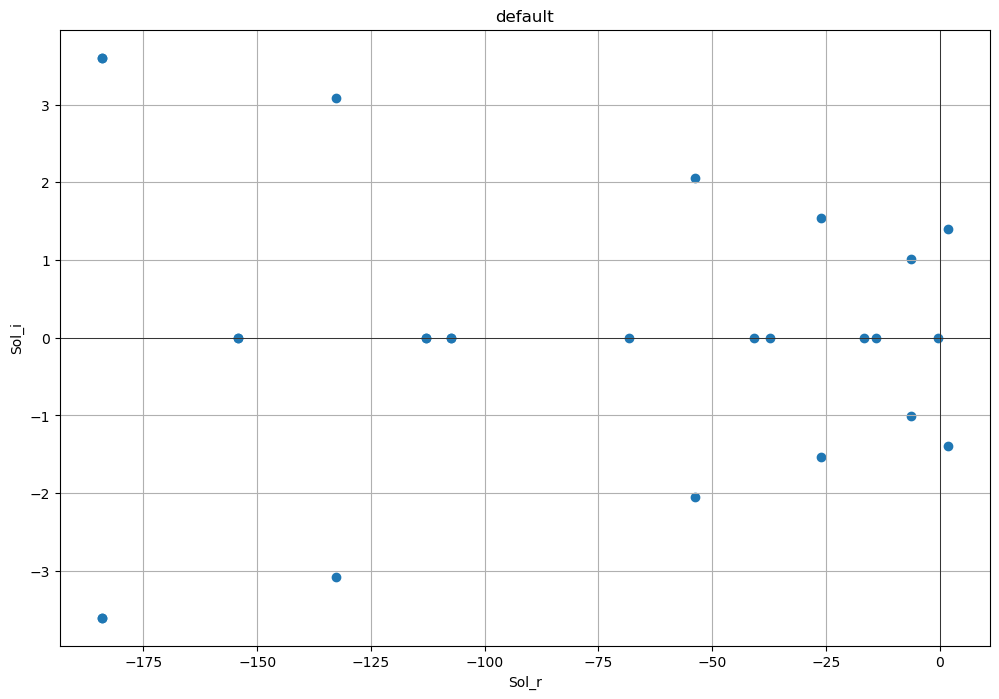

par : {'k': 10, 'D': 0.1, 'v': 0.5, 'tau': 1, 'R': 0.9, 'label': 'default'}
guess_range : ([-200, 50, 50], [0, 10, 5])
tols : (0.0001, 1e-15, 100)
26


,Sol_r,Sol_i
40,-184.052339,-3.605054e+00
105,-184.052339,-3.605054e+00
104,-184.052339,3.605054e+00
102,-184.052339,3.605054e+00
110,-154.180548,6.011784e-18
48,-154.180548,-1.782231e-17
257,-132.730377,-3.088207e+00
256,-132.730377,3.088207e+00
12,-112.817006,0.000000e+00
192,-112.817006,1.460158e-19


In [20]:
# Solve and plot for default_par

df, label, metadata = find_eig(guess_range_real=[-200,50,50], guess_range_imag=[0,10,5])
df = cluster(df, 4)
plot_single_df(df, label, metadata, filter=False)
print(len(df))
df.sort_values(by=['Sol_r'])

# Bookmark

Now we change the default parameters and define new parameter sets to obtain new systems. Then we call the solver function using the customized parameter values to see how changing each parameter will affect the eigenvalue distribution of the system:

In [ ]:
pars_list_k = []
pars_list_D = []
pars_list_tau = []
pars_list_R = []

par_list_list = [pars_list_k, pars_list_D, pars_list_tau, pars_list_R]
par_key_list = ['k', 'D', 'tau', 'R']

for i in np.linspace(0.75,1.25,3):
    for j in range(4):
        par = default_pars.copy()
        par[par_key_list[j]] = par[par_key_list[j]] * i
        par_list_list[j].append(par)

R = [-200,10,420]
I = [0,10,20]

c = 0
for P in par_list_list:
    for p in P:
        c += 1
        (df, title) = find_eig(par=p, guess_range_real=R, guess_range_imag=I)
        filename = str(c) + ".csv"
        df.to_csv(filename)

In [ ]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, df in enumerate(dataframes):
 # Filter rows based on criteria
    filtered_df = df[(df['Sol_r'] > -200) & (df['Sol_i'] > -5) & (df['Sol_i'] < 5)]
    
 # Calculate the correct index for the subplot arrangement
    col = i // 3
    row = i % 3
    
    ax = axes[row * 4 + col]
    ax.scatter(filtered_df['Sol_r'], filtered_df['Sol_i'])
    
 # Parse the 'Pars' string representation back into a dictionary
    pars_dict = ast.literal_eval(df['Pars'][0])
    
 # Check if Pars dictionary matches default_pars
    if pars_dict == default_pars:
        title = 'Default'
    else:
 # Find key-value pairs that differ from default_pars
        differing_pairs = {key: value for key, value in pars_dict.items() if value != default_pars[key]}
        title = ', '.join([f"{key}: {value}" for key, value in differing_pairs.items()])
    
    ax.set_title(title)
    ax.set_xlabel('Sol_r')
    ax.set_ylabel('Sol_i')

 # Set axis limits to ensure visibility of x=0 and y=0 lines
    ax.axhline(0, color='black', linewidth=0.5) # Horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5) # Vertical line at x=0
    ax.grid(True)

# Adjust layout to prevent overlapping labels and titles
plt.tight_layout()
plt.show()

In [ ]:
def plot_single_df(df, title, metadata, real_lower_bound=-200, real_upper_bound=10, filter_imag=5):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Filter rows based on criteria
    filtered_df = df[(df['Sol_r'] > filter_real) & (df['Sol_i'] > -filter_imag) & (df['Sol_i'] < filter_imag)]

    ax.scatter(filtered_df['Sol_r'], filtered_df['Sol_i'])
    ax.set_title(title)
    ax.set_xlabel('Sol_r')
    ax.set_ylabel('Sol_i')

    # Set axis limits to ensure visibility of x=0 and y=0 lines
    ax.axhline(0, color='black', linewidth=0.5) # Horizontal line at y=0
    ax.axvline(0, color='black', linewidth=0.5) # Vertical line at x=0
    ax.grid(True)
    plt.show()

    for key, value in metadata:
        print(f'{key} : {value}')

# Done
- Single plots from df
- **Rework char_eq**

# To Do:
- Single plots from csv files
- Group plots from csv files
- Arrange folders in git
- Consider omitting large g(x) values in dataframe rather than an if loop
- Run .py on server for multiple pars